<a href="https://colab.research.google.com/github/mehdi-nait/Heart-Failure-Symptomes-detection/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/mehdi-nait/Heart-Failure-Symptomes-detection.git

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install wandb
import wandb

In [ ]:
!wandb login

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class Dataset_seg(Dataset):
  """Creates dataset object given image and labels directory
  
  Inputs:
  -------------------
  image_dir : images directory
  label_dir : labels directory
  transform : transformations to be applied to the labels and images

  Returns : 
  -------------------
  Dataset object  
  """
    
    def __init__(self,image_dir,label_dir,transform = None):
        
        self.images = os.listdir(image_dir)
        self.images = [image_dir+x for x in self.images]
        
        self.labels = os.listdir(label_dir)
        self.labels = [label_dir+x for x in self.labels]
        self.transform = transform
        self.size_img = (256,256)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image,self.size_img)
        label = cv2.resize(label,self.size_img)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = image.to(device)
        label = label.to(device)
        return image,label
        
        

In [4]:
class Block(nn.Module):

  def __init__(self,in_channels,out_channels):
    
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3)
    self.relu  = nn.ReLU()
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3)
    

  def forward(self,x):
    
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    return x

In [5]:
class Encoder(nn.Module):

  def __init__(self,channels = (1,16,32,64)):
    super(Encoder,self).__init__()

    self.encode_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.pooling = nn.MaxPool2d(2,2)

  def forward(self,x):

    outputs = []

    for block in self.encode_blocks:

      x = block(x)
      outputs.append(x)
      x = self.pooling(x)

    return outputs

In [6]:
class Decoder(nn.Module):

  def __init__(self,channels = (64,32,16)):

    super(Decoder,self).__init__()

    self.channels = channels
    self.up_convs  = nn.ModuleList(nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1))
    self.dec_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.batch_norms = nn.ModuleList(nn.BatchNorm2d(channels[i+1]) for i in range(len(channels)-1))

  def forward(self,x,enc_features):

    for i in range(len(self.channels)-1):
      
      x = self.up_convs[i](x)
      x = self.batch_norms[i](x)
      enc_feature = self.copy_crop(enc_features[i],x)
      x = torch.cat((enc_feature,x),dim=1)
      x = self.dec_blocks[i](x)

    
    return x


  def copy_crop(self,feature,x):

    _,_,H,W = x.shape
    cropped_feature = transforms.CenterCrop([H,W])(feature)
    return cropped_feature

In [7]:
class Unet(nn.Module):

  def __init__(self, enc_channels = (1,64,128,256,512), dec_channels = (512,256,128,64),nb_classes = 1, retainDim = True, out_size=(256,256)):
    super(Unet,self).__init__()

    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)
    
    self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
    self.retainDim = retainDim
    self.outSize = out_size
    

  
  def forward(self,x):

    enc_features = self.encoder(x)

    dec_features = self.decoder(enc_features[::-1][0],enc_features[::-1][1:])
		
    map = self.head(dec_features)

    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    
  
    return map

In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [9]:
class BCE_DiceLoss(nn.Module):
  def __init__(self,weight = None,size_average = True):
    super(BCE_DiceLoss,self).__init__()
    
  def forward(self,logits,targets):
    bce = nn.BCEWithLogitsLoss()
    dice_loss = SoftDiceLoss()
    return bce(logits, targets) + dice_loss(logits, targets)

In [10]:
def create_dataset(train_dir,valid_dir,BATCH_SIZE = 10):

  train_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
  valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())

  valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
  train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

  trainSteps = len(train_dataset) // BATCH_SIZE
  testSteps = len(valid_dataset) // BATCH_SIZE

  return train_dataloader,valid_dataloader,trainSteps,testSteps

In [11]:
train_dir = "Data/Dataset/Train/"
valid_dir = "Data/Dataset/Test/"
BATCH_SIZE = 10
train_loader,valid_loader,train_steps,test_steps = create_dataset(train_dir,valid_dir,BATCH_SIZE)

In [19]:
model = Unet()
loss_function = BCE_DiceLoss()


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.99)

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [13]:
wandb.config = {
  "Loss_function" : "BCE_DiceLoss",
  "Optimizer" : "SGD W/ Momentum",
  "Image_Size" : 256,
  "U-net layers":(1,64,128,256,512,1024),
  "Learning_rate": 0.0002,
  "Epochs": 100,
  "Batch_size": 10,
  "Device" : "GPU"
}


wandb.init(config=wandb.config,project="LV-Seg", entity="mehdi-nait")


wandb: Currently logged in as: mehdi-nait (use `wandb login --relogin` to force relogin)


In [ ]:
NUM_EPOCHS = wandb.config["Epochs"]

print("[INFO] training the network...")
startTime = time.time()
model = model.cuda()
for e in tqdm(range(NUM_EPOCHS)):

  model.train()

  totalTrainLoss = 0
  totalTestLoss = 0

  for (i, (x, y)) in enumerate(train_loader):
    
    (x, y) = (x.cuda(), y.cuda())
    pred = model(x)
  
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    totalTrainLoss += loss

  with torch.no_grad():

    model.eval()

    for (x, y) in valid_loader:
        
        pred = model(x)
        totalTestLoss += loss_function(pred, y)
  
  avgTrainLoss = totalTrainLoss / train_steps
  avgTestLoss = totalTestLoss / test_steps

  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

  wandb.log({
        "Train Loss": avgTrainLoss,
        "Valid Loss": avgTestLoss})

  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))

endTime = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [15]:
EPOCH = 100
PATH = "Unet_1024.pt"
LOSS = 0.001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# Test

In [ ]:
PATH = "Unet_1024.pt"

model = Unet()
model = model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())
valid_dataloader = DataLoader(valid_dataset, batch_size = 1, shuffle = True)

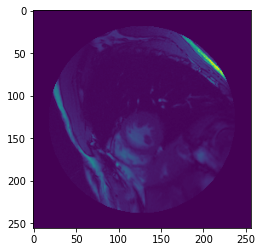

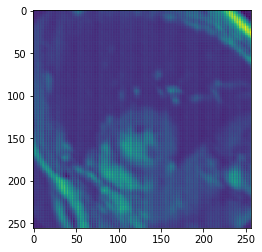

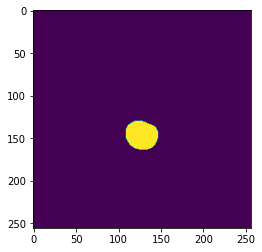

In [18]:
img,label = next(iter(valid_dataloader))

y = model.forward(img)

plt.imshow(img.cpu().squeeze())
plt.show()

output = y.cpu().detach().numpy().squeeze()
plt.imshow(output)
plt.show()

plt.imshow(label.cpu().squeeze())
plt.show()